In [1]:
import os
import numpy as np
import pandas as pd
from machine_learning.DNN.model import DNN
from machine_learning.DNN.training import train_model
from machine_learning.DNN.data_pipepline import CarData

c:\Users\~MatthijsvanGroening\.conda\envs\sdp_food\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.utils.data import DataLoader

data_dir = './data'
clean_data_file = os.path.join(data_dir, 'cleaned_data.parquet')
clean_data = pd.read_parquet(clean_data_file)

label_col = 'price'
norm_cols = ['price', 'year', 'odometer', 'lat', 'long']
batch_size = 32
val_size = 0.1
test_size = 0.1

data = CarData(clean_data, label_col, norm_cols, val_size, test_size)

train_data = DataLoader(data.train_data, batch_size=batch_size, shuffle=True)
val_data = DataLoader(data.val_data, batch_size=batch_size, shuffle=True)
# test_data = DataLoader(data.test_data, batch_size=batch_size, shuffle=True)

In [3]:
# model params
input_dim = len(train_data.dataset.dataset[0][0].shape[1])
hidden_dims = [64, 64, 64]
output_dim = 1

# training params
learning_rate = 0.001
n_epochs = 100
l2_reg = 1e-5

model_save_dir = f"./machine_learning/DNN/arc_{'_'.join(hidden_dims)}_lr_{learning_rate}_l2_{l2_reg}"

model = DNN(hidden_dims=hidden_dims, input_dim=input_dim, output_dim=output_dim)
train_model(model=model, model_save_dir=model_save_dir, 
            train_dataset=train_data, val_dataset=val_data,
            lr=learning_rate, num_epochs=n_epochs, l2=l2_reg)

train epoch 0:   6%|▌         | 576/9612 [00:02<00:32, 276.61it/s]

KeyboardInterrupt: 

In [3]:
from torch import load

model = DNN(hidden_dims=[64, 64, 64], input_dim=105, output_dim=1)
model.load_state_dict(load(os.path.join('./models', 'model_parameters')))

<All keys matched successfully>

In [4]:
# Meta data
dataset = data.val_data.dataset
data_means = data.means
data_stds = data.stds

numeric_columns = data.numeric_columns
onehot_columns = data.onehot_columns
categorical_cols = data.categorical_columns

In [ ]:
from torch import FloatTensor

def test_model(model, data, label_column, label_mean, label_std):
    if type(data) == list:
        X = np.concatenate([instance[0][None, ...] for instance in data], axis=0)
        y_true = np.concatenate([instance[1][None, ...] for instance in data], axis=0)
    else:
        X = data.drop(columns=[label_column]).copy().to_numpy()
        y_true = data[[label_column]].copy().to_numpy()
    
    model.eval()
    y_pred = model(FloatTensor(X))
    
    # Reconstruct data
    y_pred = (y_pred.detach().numpy() * label_std) + label_mean
    y_true = (y_true * label_std) + label_mean
    return y_pred[:, 0], y_true[:, 0]

test_dataset = data.val_data.dataset
y1, y2 = test_model(model, test_dataset, label_col, data_means[0], data_stds[0])


Mean true price: 18468.255617977527
Mean pred price: 18432.469
RMSE: 3955.67916290706
RMSPE: 79.78347350909387
MAE: 2687.15824961573
MedAE: 1816.5517578125


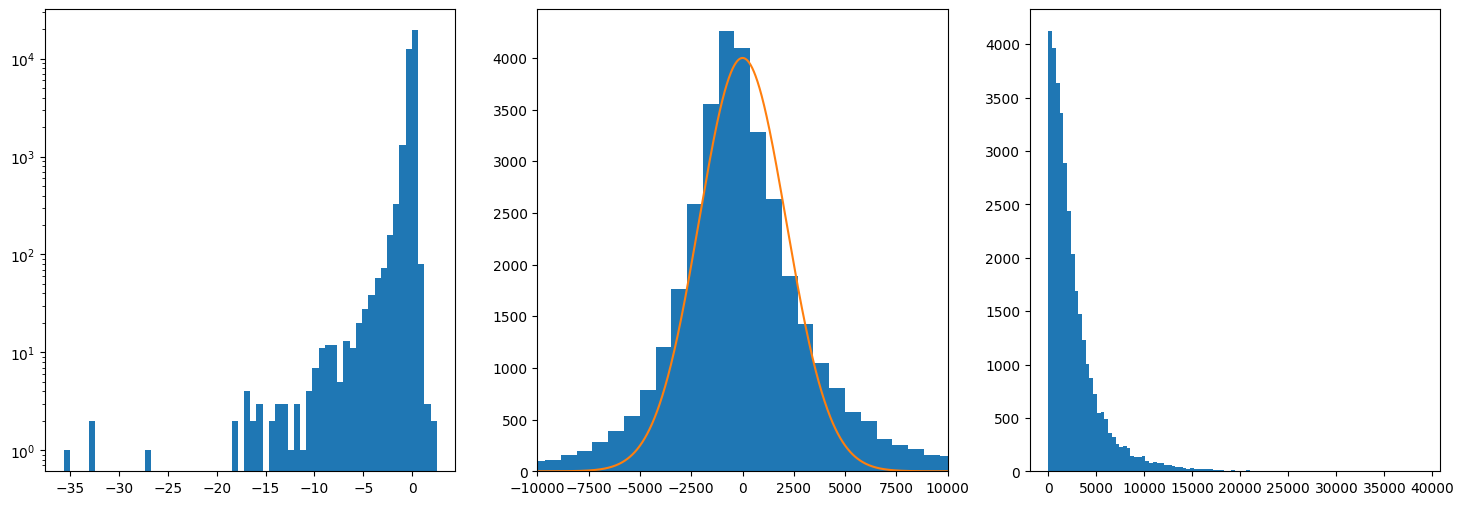

In [54]:
print('Mean true price:', np.mean(y2))
print('Mean pred price:', np.mean(y1))
print('RMSE:', np.sqrt(np.mean(np.square(y1 - y2))))
print('RMSPE:', np.sqrt(np.mean(np.square((y2 - y1) / y2))) * 100)
print('MAE:', np.mean(np.abs(y1 - y2)))
print('MedAE:', np.median(np.abs(y1 - y2)))

a = 4000
sigma = 3000

x = np.linspace(-10000, 10000, 1000)
y = a * np.exp(- x**2 / sigma**2)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].hist((y2 - y1) / y2, bins=60)
ax[0].set_yscale('log')

ax[1].hist((y2 - y1), bins=100)
ax[1].plot(x, y)
ax[1].set_xlim(-10000, 10000)
# ax[1].set_yscale('log')

ax[2].hist(np.abs(y2 - y1), bins=100)
# ax[2].set_yscale('log')
plt.show()

In [4]:


# Sample data point
for i in range(1):
    sample_idx = np.random.randint(0, len(dataset))
    X = dataset[sample_idx][0]
    y_true = dataset[sample_idx][1]

    # Predict sample label
    model.eval()
    y_pred = model(FloatTensor(X))
    
    # Reconstruct prediction
    y_pred = (y_pred.detach().numpy() * data_stds[0]) + data_means[0]

    # Reconstruct numeric data
    numeric_vals = (X[:4] * data_stds[1:]) + data_means[1:]

    # Reconstruct categorical data
    categorical_vals = list(np.array(onehot_columns)[np.where(X[4:] == 1)[0]])
    categorical_vals = {'_'.join(col.split('_')[:-1]):col.split('_')[-1] for col in categorical_vals}

    # Reconstruct label
    y_true = (y_true * data_stds[0]) + data_means[0]

    # Put all data in dictionary
    sample_data = {}
    for col, val in zip(numeric_columns, numeric_vals):
        sample_data.update({col:val})
    for col in categorical_cols:
        if col in categorical_vals:
            sample_data.update({col:categorical_vals[col]})
        else:
            sample_data.update({col:None})
    sample_data.update({'predicted price': int(y_pred[0]), 'true price': int(y_true[0])})

    # Show sample results
    print(pd.Series(sample_data).to_string())
print('done')


year                    2010.0
odometer              260100.0
lat                    41.7815
long                  -71.7187
type                     truck
paint_color              white
size                 full-size
drive                      rwd
fuel                    diesel
cylinders          6 cylinders
condition                 good
title_status             clean
manufacturer            toyota
transmission         automatic
predicted price          17793
true price                9900
done


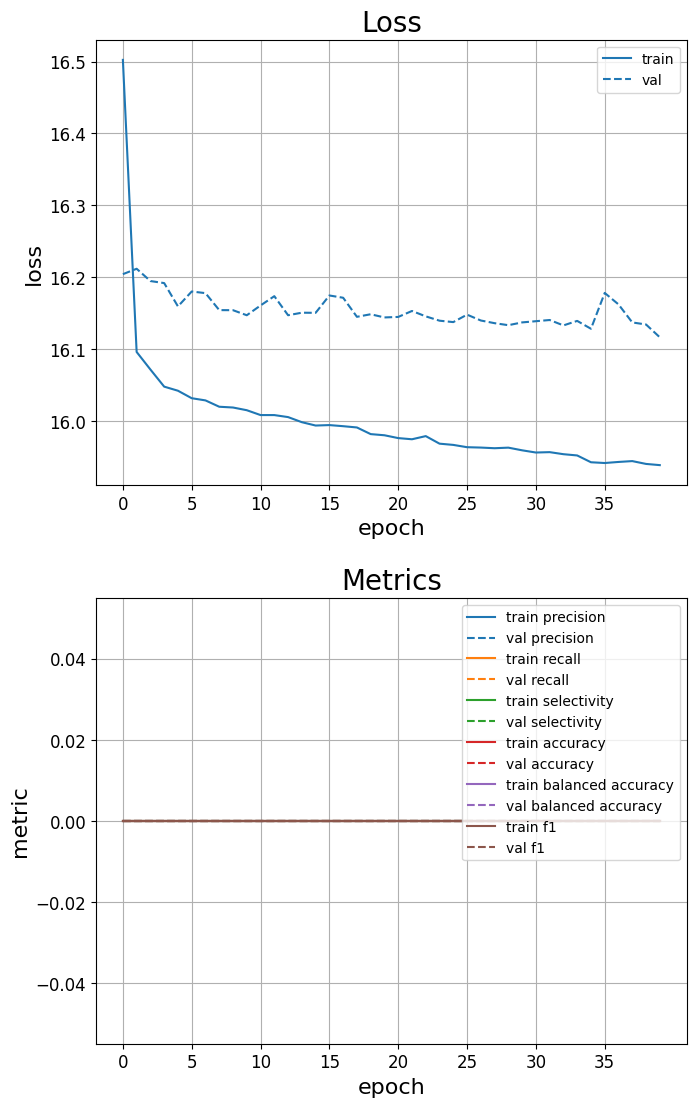

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 1, figsize=(8, 12))
fig.tight_layout(pad=6.0)

epochs = np.arange(len(metrics['train_loss']))

for mode, fmt in zip(['train', 'val'], ['-', '--']):
    metric = metrics[f'{mode}_loss']
    if len(metric) > 0:
        ax[0].plot(epochs, metric, label=mode, linestyle=fmt, c='tab:blue')

for metr, col in zip(['precision', 'recall', 'selectivity', 'accuracy', 'balanced_accuracy', 'f1'],
                        ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']):
    for mode, fmt in zip(['train', 'val'], ['-', '--']):
        metric = metrics[f'{mode}_{metr}']
        if len(metric) > 0:
            ax[1].plot(epochs, metric, label=mode + ' ' + metr.replace('_', ' '), linestyle=fmt, c=col)

labels = ['loss', 'metric']
titles = ['Loss', 'Metrics']
legend_fontsize = [10, 10]

for i in range(2):
    ax[i].set_xticks(epochs[::5])
    ax[i].set_xlabel('epoch', fontsize=16)
    ax[i].set_ylabel(labels[i], fontsize=16)
    ax[i].set_title(titles[i], fontsize=20)
    ax[i].tick_params(labelsize=12)
    ax[i].grid(True)
    ax[i].legend(fontsize=legend_fontsize[i])
# if loss_ylim is not None:
#     ax[0].set_ylim(loss_ylim)
# if metric_ylim is not None:
#     ax[1].set_ylim(metric_ylim)

# plt.savefig(os.path.join(save_dir, 'metrics.png'))
plt.show()